In [1]:
import pandas as pd
import requests
import json
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import xarray
import rioxarray

In [2]:
os.makedirs("./idw", exist_ok=True)

r_estaciones = requests.api.get("https://Geopiragua.corantioquia.gov.co/api/v1/estaciones")

estaciones = json.loads(r_estaciones.content)

df_ppt = pd.DataFrame({int(est["codigo"]):{"lat":float(est["latitud"]), "lon":float(est["longitud"])} for est in estaciones["estaciones"] if str(est["tipo"]) == "1"}).T

now = datetime.datetime.now()

start_date = (now - pd.Timedelta("7d")).strftime("%Y-%m-%d")


for i in df_ppt.index:
    r_ppt = requests.api.get(f"https://Geopiragua.corantioquia.gov.co/api/v1/estaciones/{i}/precipitacion?fecha__gte=2022-05-30&fecha__gte=2022-06-05?history")

    data = json.loads(r_ppt.content)
    
    try:
        df_ppt.loc[i, "ppt"] = np.array([i["muestra"] for i in data["results"] if float(i["muestra"]) >= 0]).astype(float).sum()
    except:
        print(i)

df_ppt.dropna().to_csv(f"{start_date}.csv", index = False)

1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
33
34
35
36
37
38
39
4
40
41
42
43
44
45
46
47
48
49
5
50
51
52
53
54
55
56
57
58
59
6
60
61
62
63
64
65
66
67
68
69
7
70
71
72
73
74
75
76
77
78
79
8
80
81
82
83
84
85
86
87
88
89
9
90
91
92
93
94
95
96
97
98


<AxesSubplot:>

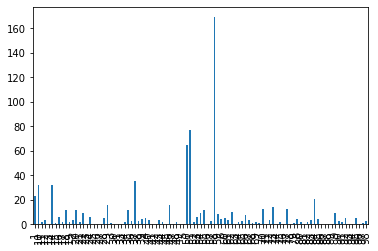

In [82]:
df_ppt.ppt.plot(kind = "bar")

In [93]:
diff_lat = abs(df_ppt.lat.min() - df_ppt.lat.max())

lats = np.linspace(df_ppt.lat.min() - diff_lat * 0.1, df_ppt.lat.max() + diff_lat * 0.1, 200)



In [94]:
diff_lon = abs(df_ppt.lon.min() - df_ppt.lon.max())

lons = np.linspace(df_ppt.lon.min() - diff_lon * 0.1, df_ppt.lon.max() + diff_lon * 0.1, 200)

In [95]:
x, y = np.meshgrid(lats, lons)

In [96]:
from photutils.utils import ShepardIDWInterpolator as idw

In [106]:
interp = idw(np.c_[df_ppt.lon, df_ppt.lat], df_ppt.ppt)

In [111]:
lluvia = interp(np.c_[x.ravel(), y.ravel()], power = 2).reshape(x.shape)
lluvia[lluvia < 1] = np.nan

,lat,lon,ppt
1,7.492328,-74.868139,0.000
11,6.059778,-75.792333,7.366
12,5.596583,-75.813861,9.144
13,5.655417,-75.882556,0.762
14,5.790806,-75.842722,2.032
...,...,...,...
91,5.769583,-75.736889,11.176
92,6.250038,-75.583064,2.032
95,5.911333,-75.659417,24.638
97,7.063944,-75.685972,5.842


In [2]:
import numpy as np
import geopandas as gpd
import requests
import json
from shapely.geometry import Point
from osgeo import gdal
import rioxarray as rio
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
from shapely.geometry import Polygon
import rioxarray

In [3]:
shp_file = "./puntos.shp"
rst_file = './interpolado.tif'

In [17]:
os.makedirs("./idw", exist_ok=True)

r_estaciones = requests.api.get("https://geopiragua.corantioquia.gov.co/api/v1/estaciones/")

estaciones = json.loads(r_estaciones.content)

df_ppt = pd.DataFrame({int(est["codigo"]):{"lat":float(est["latitud"]), "lon":float(est["longitud"])} for est in estaciones["estaciones"] if str(est["tipo"]) == "1"}).T

now = datetime.datetime.now()

start_date = (now - pd.Timedelta("7d")).strftime("%Y-%m-%d")


for i in df_ppt.index:
    r_ppt = requests.api.get(f"https://geopiragua.corantioquia.gov.co/api/v1/precipitacion/{i}?fecha__gte=2022-05-30&fecha__lt=2022-06-06&page=1&size=2016")

    data = json.loads(r_ppt.content)
    
#     try:
    df_ppt.loc[i, "ppt"] = np.array([i["muestra"] for i in data["results"] if float(i["muestra"]) >= 0]).astype(float).sum()
#     except:
#         print(i)

df_ppt = df_ppt.dropna()#.to_csv(f"{start_date}.csv", index = False)

In [19]:
gdf = gpd.GeoDataFrame(df_ppt, geometry=[Point(x, y) for x, y in zip(df_ppt.lon, df_ppt.lat)], crs="EPSG:4326")
gdf = gdf.loc[gdf.ppt > 0]
gdf.to_file(shp_file)

/opt/homebrew/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [20]:
shp_file = "./puntos.shp"
rst_file = './interpolado.tif'

In [21]:
ulx = gdf.lon.min() - 0.2
lrx = gdf.lon.max() + 0.2
lry = gdf.lat.min() - 0.2
uly = gdf.lat.max() + 0.2


In [58]:
rasterDs = gdal.Grid(rst_file, 
                     shp_file, 
                     format = 'GTiff',
                     algorithm = "invdistnn:power=2.0:smothing=0:radius=100.0:max_points=12:min_points=0:nodata=0.0", 
                     zfield = 'ppt',
                     width = 128,
                     height = 128,
                     outputBounds = [ulx, uly, lrx, lry])



# rasterDs.FlushCache()

# del rasterDs



In [59]:
poligonos = requests.get("https://Geopiragua.corantioquia.gov.co/api/v1/localizacion/territoriales")

In [60]:
territoriales = gpd.GeoDataFrame(geometry=[Polygon(json.loads(poligonos.content)["values"][i]["poly"]["coordinates"][0]) for i in range(len(json.loads(poligonos.content)["values"]))])

territoriales = territoriales.dissolve()

ds = rioxarray.open_rasterio(rst_file)

dsx = ds.rio.clip(territoriales.geometry)

lons, lats = np.meshgrid(dsx.x, dsx.y)

lats = lats.ravel()
lons = lons.ravel()

masked = dsx.where(dsx > 0)
masked = masked.fillna(0)
vals = masked[0].values.ravel()

masked.rio.to_raster("../../../../Downloads/planet_scope.tif")

In [398]:
mask = np.isfinite(vals)

In [399]:
data = {"x": lons[mask].round(3).tolist(),
"y": lats[mask].round(3).tolist(),
"z": vals[mask].round(1).tolist()}

In [373]:
with open("prueba_poligonos", "w") as f:
    f.write(str(data))
    
# !pbcopy < prueba_poligonos

In [338]:
round(abs(lons[0] - lons[1]), 5)

0.00601

In [341]:
dsx.y[0] - dsx.y[1]

<xarray.DataArray 'y' ()>
array(0.00692467)
Coordinates:
    spatial_ref  int64 0

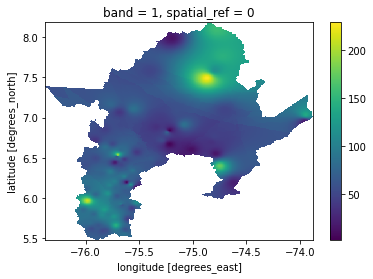

In [304]:
masked.plot()

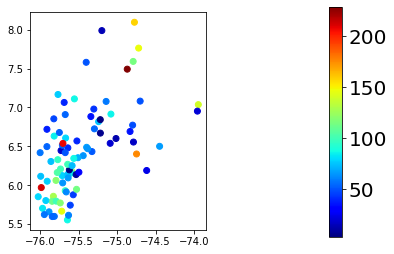

In [308]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
vmin = gdf.ppt.min()
vmax = gdf.ppt.max()
gdf.plot(ax=ax,column = "ppt",cmap = 'jet',legend = False, lw = 1, vmin = vmin, vmax = vmax)

cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

cbr.ax.tick_params(labelsize=20) 